In [3]:
import sys
import numpy as np
from numpy.random import MT19937, PCG64, PCG64DXSM, Philox, SFC64, Generator, SeedSequence
from randomgen import ChaCha, AESCounter, HC128, SPECK128, ThreeFry
from tqdm import tqdm
import time
import pickle
import cv2 
from os.path import exists
sys.path.insert(0,"../randomness_testsuite")
from FrequencyTest import FrequencyTest
from RunTest import RunTest
from Matrix import Matrix
from Spectral import SpectralTest
from TemplateMatching import TemplateMatching
from Universal import Universal
from Complexity import ComplexityTest
from Serial import Serial
from ApproximateEntropy import ApproximateEntropy
from CumulativeSum import CumulativeSums
from RandomExcursions import RandomExcursions
import matplotlib.pyplot as plt
import bitstring
from glob import glob
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util import plotting

In [23]:
# Code created by Ferhat Özgur Catak. 
# Based on paper: 5G-SRNG: 5G Spectrogram-based Random Number
# Generation for Devices with Low Entropy Sources
files = glob('../GeneratedData\\NR*.png')
num_of_files = len(files)

# def get_entropy_spectrum(c, k, sel_img_idx):
def get_entropy_spectrum(c, k, sel_img_idx, rng):
    sel_img = files[sel_img_idx]
    img = cv2.imread(sel_img)
    start_x = rng.integers(img.shape[0] - c)
    start_y = rng.integers(img.shape[1] - k)


    selected_spectogram = img[start_x:start_x+c, start_y:start_y+k, :].flatten()
    
    random_bits = bitstring.BitArray(float=selected_spectogram[0], length=32)
    
    for i in range(1,selected_spectogram.shape[0]):
        tmp = bitstring.BitArray(float=selected_spectogram[i], length=32) 
        random_bits = random_bits ^ tmp # xor
        random_bits = random_bits ^ random_bits << 13
        random_bits = random_bits ^ random_bits >> 17
        random_bits = random_bits ^ random_bits << 5
    
    return random_bits.uintle, random_bits


Some first experiments of running the code above shows that it would take about 14 and a half day to run the code above on a free account on google colab.
(This is in regards to pickling all entropies), That is using the plt.imread (100 it/s). Using the cv2.imread (130 it/s)The time is reduced a bit over 11 days.
If this were to be done for a single image it would take approximately 8 minutes.

Changed according to this stackOverflow
https://stackoverflow.com/questions/44078327/fastest-approach-to-read-thousands-of-images-into-one-big-numpy-array

In [5]:
# 1st
def get_random_numbers(FRAME_SIZE_VECTOR, generator):
    NUM_OF_ELEMENTS = 512
    SIZE = 2012
    c_list = np.linspace(1, 369, num=369).astype(int)
    k_list = np.linspace(1, 169, num=169).astype(int)
    c_list = [FRAME_SIZE_VECTOR[0]]
    k_list = [FRAME_SIZE_VECTOR[1]]

    # This creates the entropies (2017 entropies) used as seed for the RNG.
    rngs = []
    np.random.shuffle(c_list)
    np.random.shuffle(k_list)
    rng = np.random.default_rng(12345)
    for c_k_idx in range(len(c_list)): 
        c = c_list[c_k_idx]
        k = k_list[c_k_idx]
        sel_img_idx = rng.integers(0,num_of_files)
        entropy_val = get_entropy_spectrum(c,k,sel_img_idx, rng)
        # To be able to run several runs in a row with different rngs used generator variable to set it differently.
        if generator == "PCG64":
            rngs.append(Generator(PCG64(SeedSequence(entropy_val))))
        elif generator == "PCG64DXSM":
            rngs.append(Generator(PCG64DXSM(SeedSequence(entropy_val))))
        elif generator == "MT19937":
            rngs.append(Generator(MT19937(SeedSequence(entropy_val))))
        elif generator == "Philox":
            rngs.append(Generator(Philox(SeedSequence(entropy_val))))
        elif generator == "SFC64":
            rngs.append(Generator(SFC64(SeedSequence(entropy_val))))
        elif generator == "AESCounter":
            rngs.append(Generator(AESCounter(SeedSequence(entropy_val))))
        elif generator == "ChaCha":
            rngs.append(Generator(ChaCha(SeedSequence(entropy_val))))
        elif generator == "HC128":
            rngs.append(Generator(HC128(SeedSequence(entropy_val))))
        elif generator == "SPECK128":
            rngs.append(Generator(SPECK128(SeedSequence(entropy_val))))
        elif generator == "ThreeFry":
            rngs.append(Generator(ThreeFry(SeedSequence(entropy_val))))


    # Creates a list of len = 2012 * 2048 random integers.
    rand_int_sec = []
    for c_k_idx in range(len(c_list)): 
        for i in range(SIZE):
            tmp = rngs[c_k_idx].integers(0, NUM_OF_ELEMENTS, 2048)
            rand_int_sec.extend(tmp) 
    
    rand_binary_sec = []
    # converts the integers to binary and fills it to keep 
    for i in range(len(rand_int_sec)):
        rand_binary_sec.append("{0:09b}".format(rand_int_sec[i]) )
    binary_data = "".join(rand_binary_sec)
    
    return binary_data

In [19]:
# # 2nd

class DiscreteFourierRandomMax(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=1,
                         n_ieq_constr=1,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = SpectralTest.spectral_test(numbers)
        

        out["F"] = - f1[0]
        out["G"] = 0.01 - f1[0]
        
problem = DiscreteFourierRandomMax("PCG64")

In [6]:
class NIST_SP800_22rev1a_max(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=16,
                         n_ieq_constr=16,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = FrequencyTest.monobit_test(numbers)
        f2 = FrequencyTest.block_frequency(numbers)
        f3 = RunTest.run_test(numbers)
        f4 = RunTest.longest_one_block_test(numbers)
        f5 = Matrix.binary_matrix_rank_text(numbers)
        f6 = SpectralTest.spectral_test(numbers)
        f7 = TemplateMatching.non_overlapping_test(numbers)
        f8 = TemplateMatching.overlapping_patterns(numbers)
        f9 = Universal.statistical_test(numbers)
        f10 = ComplexityTest.linear_complexity_test(numbers)
        f11 = Serial.serial_test(numbers)
        f12 = ApproximateEntropy.approximate_entropy_test(numbers)
        f13_0 = CumulativeSums.cumulative_sums_test(numbers,0)
        f13_1 = CumulativeSums.cumulative_sums_test(numbers,1)
        f14 = RandomExcursions.random_excursions_test(numbers)
        f15 = RandomExcursions.variant_test(numbers)
        f14_avg, f15_avg = 0,0
        for i in range(len(f14)):
            f14_avg += f14[i][3]
        for i in range(len(f15)):
            f15_avg += f15[i][3]
        f14_avg, f15_avg = f14_avg / len(f14),f15_avg/len(f15)
        f11_avg = ((f11[0][0] + f11[1][0]) / 2)

        out["F"] = [- f1[0],- f2[0],- f3[0],- f4[0],- f5[0],- f6[0],- f7[0],- f8[0],
            - f9[0],- f10[0],- f11_avg,- f12[0],- f13_0[0],- f13_1[0],- f14_avg,- f15_avg]
        out["G"] = [0.01 - f1[0],
                    0.01 - f2[0],
                    0.01 - f3[0],
                    0.01 - f4[0],
                    0.01 - f5[0],
                    0.01 - f6[0],
                    0.01 - f7[0],
                    0.01 - f8[0],
                    0.01 - f9[0],
                    0.01 - f10[0],
                    0.01 - f11_avg,
                    0.01 - f12[0],
                    0.01 - f13_0[0],
                    0.01 - f13_1[0],
                    0.01 - f14_avg,
                    0.01 - f15_avg]
        
problem2 = NIST_SP800_22rev1a_max("PCG64")

In [7]:
# # 3rd
algortihm = NSGA2(
            pop_size = 3, 
            n_offsprings=3,
            sampling=IntegerRandomSampling(),
            crossover=SBX(vtype=float, repair=RoundingRepair()),
            mutation=PM(vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True)



In [8]:
# May choose to not use this and the algorithm terminates when no significant progress has been made.
termination = get_termination("n_gen", 3)

In [27]:
# generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
generators = ["ChaCha", "AESCounter", "HC128", "SPECK128", "ThreeFry"]
results1 = []
for generator in tqdm(generators):
    problem = DiscreteFourierRandomMax(generator)
    tic = time.perf_counter()
    res1 = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    toc = time.perf_counter()
    results1.append(res1)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res1.X)
    print("Function value: %s" % res1.F)    
    print("Constraint violation: %s" % res1.CV)
    

  0%|          | 0/5 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.3518705596 |         ideal


 20%|██        | 1/5 [17:45<1:11:03, 1065.82s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using ChaCha: 1065.8140186999226 seconds
Best solution found: [278 123]
Function value: [-0.92245209]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0612038050 |         ideal


 40%|████      | 2/5 [29:30<42:39, 853.20s/it]   

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using AESCounter: 704.3571579999989 seconds
Best solution found: [165 145]
Function value: [-0.985092]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.0004374490 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.5396901542 |         ideal


 60%|██████    | 3/5 [44:16<28:56, 868.20s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using HC128: 886.0483074999647 seconds
Best solution found: [309 148]
Function value: [-0.86882144]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


 80%|████████  | 4/5 [59:45<14:52, 892.25s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using SPECK128: 929.113015400013 seconds
Best solution found: [189 150]
Function value: [-0.9935075]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


100%|██████████| 5/5 [1:14:31<00:00, 894.38s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using ThreeFry: 886.5476238999981 seconds
Best solution found: [129 130]
Function value: [-0.94425739]
Constraint violation: [0.]


# CSPRNG results
ChaCha:  17m 46 sec; 0.92245209  
AESCounter: 11m 24 sec; 0.985092  
HC128: 14m 46sec ; 0.86882144  
SPECK128: 15m 29 sec; 0.9935075  
ThreeFry: 14m 47 sec; 0.94425739  

# PRNG results
A test with all generators for only SPectral test.   
PCG64: 6m 22s, 0.93322868  
PCG64DXSM: 10m 8s 0.89164475  
MT19937: 7m 45s 0.88426397  
Philox: 6m 12s 0.88212301  
SFC64: 6m 4s 0.99807628  

36m 8.2s total  

Short test with old way of creating rng with numpy: 6m 45.6s  
https://numpy.org/doc/stable/reference/random/index.html#random-quick-start  
Short first test with new way of creating rng with numpy:  9m 21.2s  
Short Second test with new way of creating rng with numpy:  7m 1.2s  
Short third test with new way (PCG64) of creating rng with numpy:  5m 2.2s  
Short third test with new way (PCG64DXSM) of creating rng with numpy:  7m 11.8s  
Short third test with new way (MT19937) of creating rng with numpy:  10m 3.9s   
Short third test with new way (Philox) of creating rng with numpy:  
Short third test with new way (SFC64) of creating rng with numpy:   


In [28]:
# generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
generators = ["ChaCha", "AESCounter", "HC128", "SPECK128", "ThreeFry"]

results = []
for generator in tqdm(generators):
    problem = NIST_SP800_22rev1a_max(generator)
    tic = time.perf_counter()
    res = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    toc = time.perf_counter()
    results.append(res)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res.X)
    print("Function value: %s" % res.F)
    print("Constraint violation: %s" % res.CV)
    print()
    

  0%|          | 0/5 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


 20%|██        | 1/5 [7:34:10<30:16:42, 27250.70s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  5.6201423625 |         ideal
Time spent optimizing using ChaCha: 27249.929807900102 seconds
Best solution found: [[312   5]
 [292  13]
 [ 41   6]]
Function value: [[-0.62250602 -0.40473664 -0.33924262 -0.0297941  -0.13482982 -0.20808089
  -0.2840336  -0.29372388 -0.23163032 -0.04416411 -0.31579877 -0.81045471
  -0.29364644 -0.66756235 -0.44072324 -0.47543387]
 [-0.10677247 -0.1457705  -0.95539743 -0.20553471 -0.65988527 -0.09487143
  -0.10867085 -0.03768126 -0.94715241 -0.99208608 -0.55349134 -0.93599842
  -0.01039514 -0.18047082 -0.40798749 -0.34689142]
 [-0.82814155 -0.81870398 -0.10799287 -0.75254907 -0.07798923 -0.23115898
  -0.43660554 -0.33092918 -0.65465639 -0.56453506 -0.04987331 -0.09724001
  -0.6278353  -0.82853359 -0.59053837 -0.55512371]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |

 40%|████      | 2/5 [15:08:08<22:42:09, 27243.33s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9765688575 |         ideal
Time spent optimizing using AESCounter: 27238.13507900003 seconds
Best solution found: [[127 154]
 [ 58 158]
 [120  14]]
Function value: [[-0.98637451 -0.52930233 -0.36522478 -0.77364921 -0.54064207 -0.85484742
  -0.05485064 -0.04840921 -0.60155021 -0.95147145 -0.05320967 -0.49000054
  -0.76995485 -0.7857129  -0.73080129 -0.74523987]
 [-0.98637451 -0.47078854 -0.04084774 -0.62002878 -0.59963007 -0.42676686
  -0.33029106 -0.82937103 -0.3590192  -0.06208782 -0.60205594 -0.73114035
  -0.91470649 -0.92600015 -0.60343246 -0.769481  ]
 [-0.21517608 -0.31909127 -0.42889265 -0.71233436 -0.13853227 -0.99687395
  -0.38097859 -0.1811964  -0.81135115 -0.93356934 -0.52548583 -0.94580379
  -0.34571388 -0.1498174  -0.68281798 -0.61888972]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+0

 60%|██████    | 3/5 [22:58:45<15:23:13, 27696.95s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  0.8522945306 |         ideal
Time spent optimizing using HC128: 28236.71040750004 seconds
Best solution found: [[ 56 168]
 [274 141]
 [ 18 159]]
Function value: [[-0.49204812 -0.52685147 -0.57668275 -0.2312386  -0.71205853 -0.70369284
  -0.29569145 -0.11877897 -0.51311193 -0.145518   -0.67413161 -0.33718634
  -0.85977825 -0.33579799 -0.43220482 -0.15665965]
 [-0.87706896 -0.39648977 -0.46273942 -0.19139857 -0.29635173 -0.97163103
  -0.89684405 -0.49484839 -0.635999   -0.25181923 -0.34875802 -0.54544062
  -0.77861108 -0.6343011  -0.56670387 -0.49978859]
 [-0.72774605 -0.78309759 -0.77057934 -0.28159871 -0.22430836 -0.73729711
  -0.63817079 -0.4956066  -0.92307996 -0.76054225 -0.03721269 -0.87399466
  -0.5510864  -0.86638352 -0.30591076 -0.37880202]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  

 80%|████████  | 4/5 [30:28:18<7:36:50, 27411.00s/it] 

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.3868179452 |         ideal
Time spent optimizing using SPECK128: 26972.602159000002 seconds
Best solution found: [[ 31 119]
 [212 157]
 [ 31  50]]
Function value: [[-0.64072525 -0.86667273 -0.18982771 -0.14460553 -0.19755722 -0.40331023
  -0.1756548  -0.02575713 -0.08363649 -0.25820054 -0.9709969  -0.60490177
  -0.57406611 -0.25294701 -0.38008232 -0.53031439]
 [-0.6199548  -0.96170508 -0.38392772 -0.17465257 -0.90865262 -0.68898617
  -0.14951906 -0.09099202 -0.02193085 -0.22527848 -0.94743579 -0.30726968
  -0.33237278 -0.73314853 -0.48118867 -0.48271155]
 [-0.07675111 -0.78153694 -0.53358543 -0.85630763 -0.47419287 -0.3390853
  -0.47419529 -0.33625453 -0.85863441 -0.91712792 -0.39185503 -0.96503648
  -0.10742698 -0.11488971 -0.67800407 -0.70908199]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 

100%|██████████| 5/5 [37:56:58<00:00, 27323.76s/it]  

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.1445645865 |         ideal
Time spent optimizing using ThreeFry: 26920.53247069998 seconds
Best solution found: [[160 134]
 [203 136]
 [160 117]]
Function value: [[-0.38323268 -0.57367503 -0.07683979 -0.67300064 -0.56304554 -0.67263577
  -0.94269235 -0.03041928 -0.80702585 -0.39387899 -0.18087314 -0.7121479
  -0.46991449 -0.4163345  -0.52096617 -0.47656426]
 [-0.53219745 -0.3273399  -0.22742903 -0.74548252 -0.31183815 -0.72370047
  -0.5321197  -0.34691119 -0.17223476 -0.79604357 -0.53750432 -0.43667436
  -0.6006097  -0.75099414 -0.45824483 -0.42140634]
 [-0.83505847 -0.58320167 -0.94422501 -0.87393995 -0.86542014 -0.90118215
  -0.68107805 -0.33098301 -0.97035087 -0.74397315 -0.67640632 -0.21211336
  -0.55249917 -0.74300375 -0.44628589 -0.39771575]]
Constraint violation: [[0.]
 [0.]
 [0.]]



# PRNGs
First run of all RNGs and all tests took over 26 hours. 1597m 17.9s
Second with the use of cv2 for images took 1577m 32.5s
Third with no other programs running and no other usage of the computer 1523m 18.8s

An improvement of only 20 minutes, indicates that the main improvement for timing either lies in the NIST tests or pymoo.


# CSPRNGs
A full run took: 37 hours 56 minutes and 58.9 seconds. That is approximately 10 hours more than it took to run optimization with the RNGs


In [29]:
import pymoo
allres = pymoo.core.result.Result()
n = 0
for res in results:
    if n == 0:
        allres.X = res.X
        allres.F = res.F
        allres.history = res.history
    else:
        allres.X = np.append(allres.X, res.X, axis=0)
        allres.F = np.append(allres.F, res.F, axis=0)
        allres.history = np.append(allres.history, res.history, axis=0)
    n += 1

    

Best regarding ASF: Point 
i = 7

Best regarding Pseudo Weights: Point 
j = 14



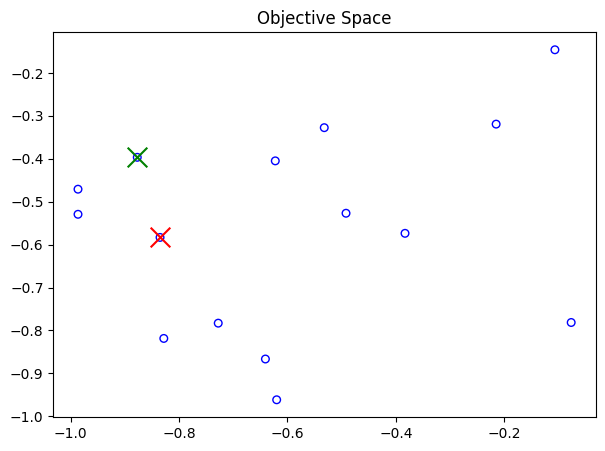

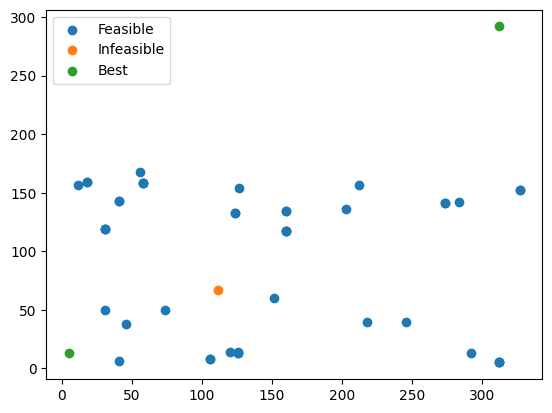

In [30]:
# https://pymoo.org/getting_started/part_3.html
F = allres.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.decomposition.asf import ASF
decomp = ASF()
weights = np.array([0.0625]*16)
i = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \ni = %s\n" % (i))
j = PseudoWeights(weights).do(nF)
print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
# print(nF[:,0], nF[:,1])
plt.figure(figsize=(7, 5))
plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()
_X = np.row_stack([a.pop.get("X") for a in allres.history])
feasible = np.row_stack([a.pop.get("feasible") for a in allres.history])[:, 0]

plotting.plot(_X[feasible], _X[np.logical_not(feasible)], allres.X[None,:]
            , labels=["Feasible", "Infeasible", "Best"])

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[0.28506286 1.         0.        ] [0.61516829 1.         0.        ]


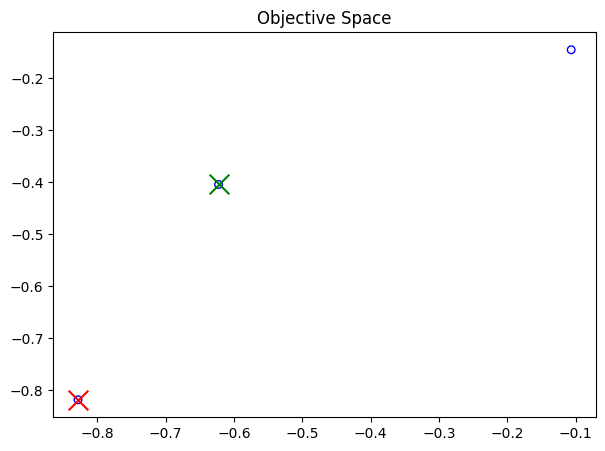

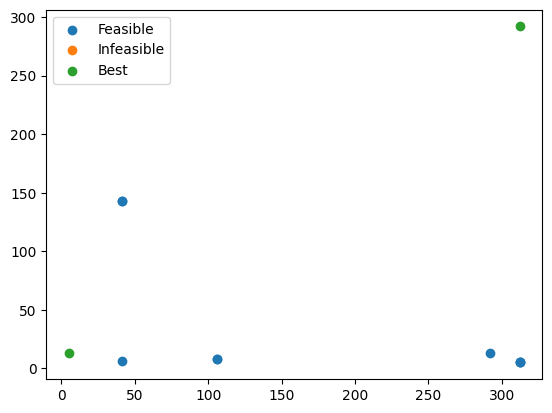

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 0

[0. 0. 1.] [0.         0.27835731 1.        ]


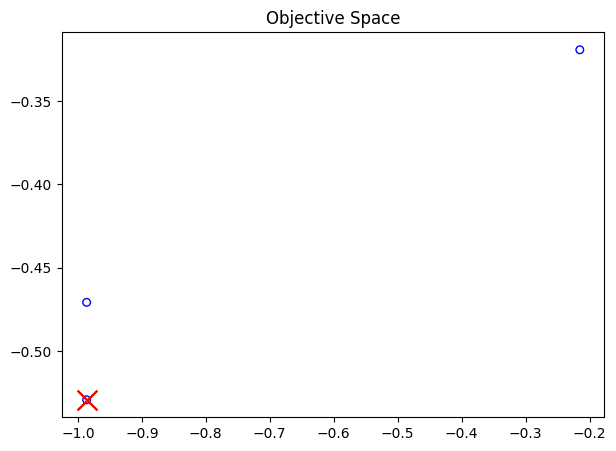

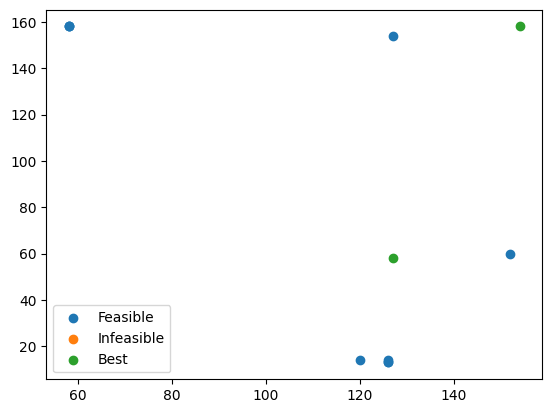

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[1.         0.         0.38783071] [0.66280634 1.         0.        ]


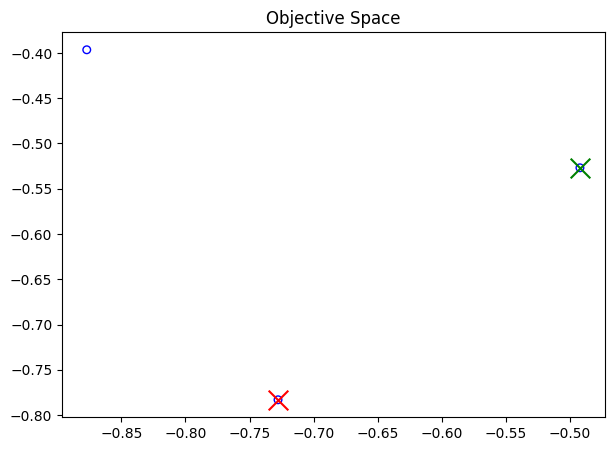

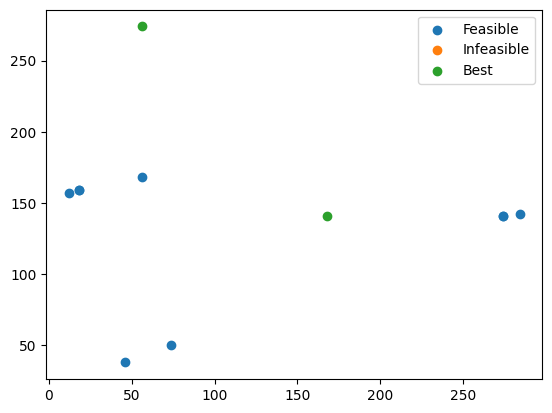

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[0.         0.03682873 1.        ] [0.52746476 0.         1.        ]


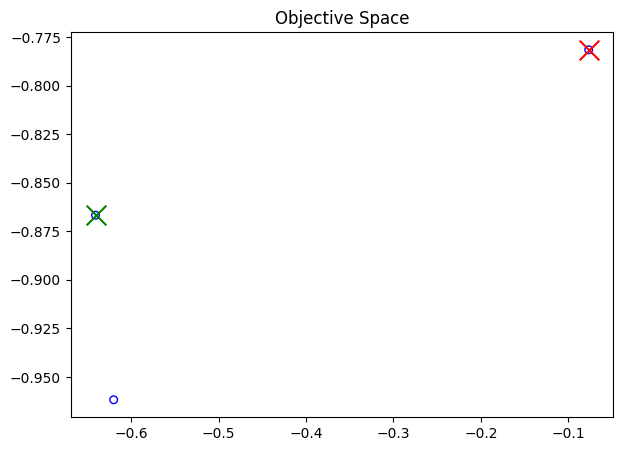

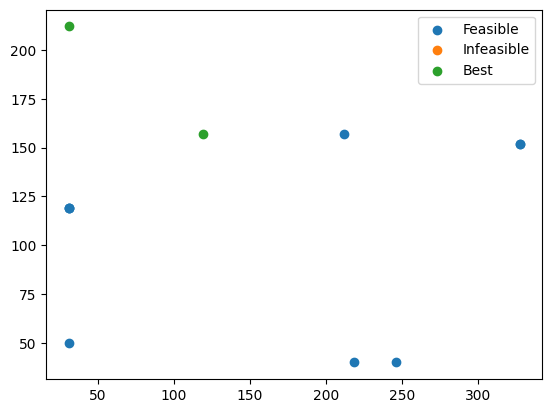

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[1.         0.67030485 0.        ] [0.03723354 1.         0.        ]


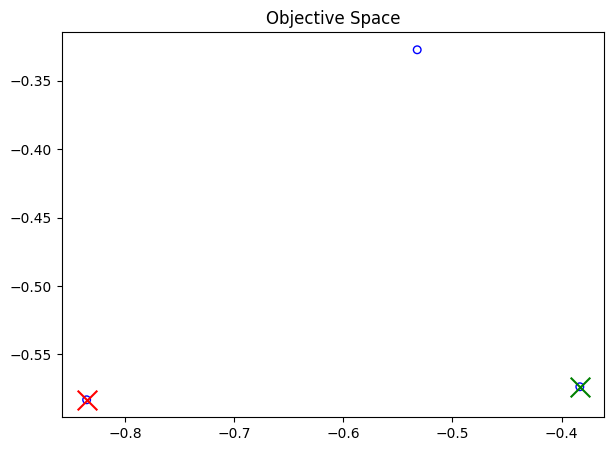

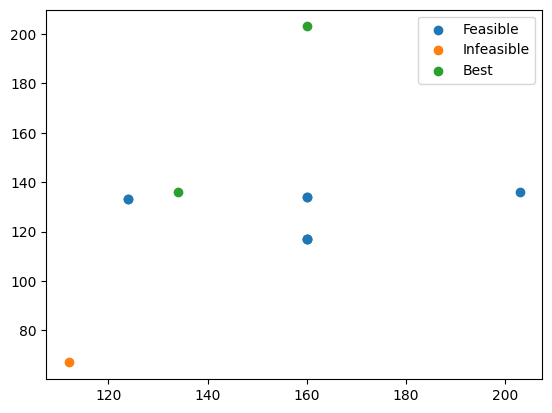

In [31]:
# https://pymoo.org/getting_started/part_3.html
for res in results:
    F = res.F
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    # fl = F.min(axis=0)
    # fu = F.max(axis=0)
    # for i in range(len(fl)):
    #     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

    fl = nF.min(axis=0)
    fu = nF.max(axis=0)
    from pymoo.mcdm.pseudo_weights import PseudoWeights
    from pymoo.decomposition.asf import ASF
    decomp = ASF()
    weights = np.array([0.0625]*16)
    i = decomp.do(nF, 1/weights).argmin()
    print("Best regarding ASF: Point \ni = %s\n" % (i))
    j = PseudoWeights(weights).do(nF)
    print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
    # for i in range(len(fl)):
    #     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
    print(nF[:,0], nF[:,1])
    plt.figure(figsize=(7, 5))
    plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
    plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
    plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
    plt.title("Objective Space")
    plt.show()
    _X = np.row_stack([a.pop.get("X") for a in res.history])
    feasible = np.row_stack([a.pop.get("feasible") for a in res.history])[:, 0]

    plotting.plot(_X[feasible], _X[np.logical_not(feasible)], res.X[None,:]
              , labels=["Feasible", "Infeasible", "Best"])